# I. Visualisation du paysage ferroviaire SNCF

Nous allons dans un premier temps nous intéresser à la répartition des gares sur le sol français. Le nombre de gares en France étant vraiment élevé, nous nous restreindrons aux gares les plus "importantes" en nous basant sur le critère de la fréquentation pour déterminer quelles gares nous étudierons.

<span style="color: #D32F2F">**1. Importation de modules nécessaires et des données**</span>

In [1]:
import pandas as pd
import requests
import folium
import matplotlib.pyplot as plt
import math
import numpy as np
from fonctions import *

In [2]:
#importation de la liste des gares, API SNCF
df_gares = importer("https://ressources.data.sncf.com/api/v2/catalog/datasets/liste-des-gares/exports/json?limit=-1&offset=0&timezone=UTC")
df_gares.head(2)

,code_uic,libelle,fret,voyageurs,code_ligne,rg_troncon,pk,commune,departemen,idreseau,idgaia,x_l93,y_l93,x_wgs84,y_wgs84,c_geo,geo_point_2d,geo_shape
0,87755223,Bandol,N,O,930000,1,050+607,BANDOL,VAR,3077,29a5a626-dfbc-11e3-a2ff-01a464e0362d,923833.7169,6.230702e+06,5.749816,43.140491,"{'lon': 5.749815526229215, 'lat': 43.140491048...","{'lon': 5.749815526229215, 'lat': 43.140491047...","{'type': 'Feature', 'geometry': {'coordinates'..."
1,87696179,Pouilly-sur-Loire,O,O,750000,1,214+004,POUILLY-SUR-LOIRE,NIEVRE,6141,297a4c76-dfbc-11e3-a2ff-01a464e0362d,697358.2537,6.686913e+06,2.965051,47.282528,"{'lon': 2.965051211539136, 'lat': 47.282528482...","{'lon': 2.965051211539134, 'lat': 47.282528481...","{'type': 'Feature', 'geometry': {'coordinates'..."


In [3]:
#importation des données sur la frequentation des gares, API SNCF
df_freq_gares = importer("https://ressources.data.sncf.com/api/v2/catalog/datasets/frequentation-gares/exports/json?limit=-1&offset=0&timezone=UTC")
df_freq_gares

,nom_gare,code_uic_complet,code_postal,segmentation_drg,total_voyageurs_2021,total_voyageurs_non_voyageurs_2021,total_voyageurs_2020,total_voyageurs_non_voyageurs_2020,total_voyageurs_2019,total_voyageurs_non_voyageurs_2019,total_voyageurs_2018,total_voyageurs_non_voyageurs_2018,totalvoyageurs2017,total_voyageurs_non_voyageurs_2017,total_voyageurs_2016,total_voyageurs_non_voyageurs_2016,total_voyageurs_2015,total_voyageurs_non_voyageurs_2015
0,Abbaretz,87481614,44170,c,27466,27466,22773,22773,38473,38473,38027,38027,35637,35637,33021,33021,35989,35989
1,Agay,87757559,83530,c,25094,25094,15390,15390,22284,22284,15093,15093,14154,14154,19240,19240,19121,19121
2,Aigueperse,87734129,63260,c,55143,55143,50677,50677,75954,75954,70745,70745,77218,77218,78088,78088,75873,75873
3,Aigues-Mortes,87775858,30220,c,8201,8201,5683,5683,6146,6146,5311,5311,4822,4822,3546,3546,3917,3917
4,Aime - La Plagne,87741769,73210,b,60161,75201,71603,89504,105825,132281,104267,130333,106398,132998,105331,131663,101243,126554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2965,Épluches,87276147,95310,c,64775,64775,33122,33122,82821,82821,87088,87088,74693,74693,70353,70353,68305,68305
2966,Étainhus - Saint-Romain,87413328,76430,c,49644,49644,42897,42897,63166,63166,51343,51343,53959,53959,55746,55746,62116,62116
2967,Étang-sur-Arroux,87694141,71190,c,91060,91060,76286,76286,76539,76539,67299,67299,72528,72528,71592,71592,81646,81646
2968,Évian-les-Bains,87745679,74500,b,167516,209395,116019,145024,171310,214137,153441,191801,184932,231165,173811,217264,187774,234717


In [4]:
#comparaison du nombre de données (moins de données sur la fréquentation)
print(len(df_freq_gares))
print(len(df_gares))

2970
3819


<span style="color: #D32F2F">**2. Constitution de la base de données (nettoyage, fusion, et concaténation de données)**</span>

In [27]:
#Harmonisation du nom de la colonne code_uic en vue du merge
df_freq_gares.rename(columns = {'code_uic_complet':'code_uic'}, inplace = True)

In [28]:
#On regarde quelles gares du datafrale "liste des gares" ne sont pas dans le dataframe "frequentations"
outer_merged = pd.merge(df_gares, df_freq_gares, how="outer", on=["code_uic"])
outer_merged[outer_merged['nom_gare'].isna()==True][['code_uic', 'libelle']]

,code_uic,libelle
3,87784488,Cases-de-Pène
12,87396671,La Chartre-sur-le-Loir
35,87271320,La Courneuve-Dugny
39,87172411,Margut-Fromy
49,87172593,Vouziers
...,...,...
3785,87286807,Genech
3793,87755835,La Motte-Ste-Rosseline
3799,87729210,Port-Fluvial-de-Chalon-sur-Saône
3801,87286252,Rougebarre


Ce sont de petites gares. Comme nous nous intéressons aux gares les plus fréquentées, non allons considérer seulement celles de la database des fréquentation.


In [29]:
#Fusion des dataframes sur la base de df_freq_gares avec un left merge
left_merged = pd.merge(df_freq_gares, df_gares, how="left", on=["code_uic"])
df_gares_merged = left_merged[['code_uic','total_voyageurs_non_voyageurs_2020', 'nom_gare', 'x_wgs84','y_wgs84']]
df_gares_merged.head()

,code_uic,total_voyageurs_non_voyageurs_2020,nom_gare,x_wgs84,y_wgs84
0,87481614,22773,Abbaretz,-1.524313,47.555462
1,87757559,15390,Agay,6.856677,43.431734
2,87734129,50677,Aigueperse,3.198198,46.014744
3,87775858,5683,Aigues-Mortes,4.191092,43.570880
4,87741769,89504,Aime - La Plagne,6.648695,45.554397


Comme il sera nécessaire de passer au log pour la colonne fréquentation, il faut gérer les cas où cette colonne vaut 0.
Lorsque la fréquentation vaut 0, la gare ne nous intéresse pas (la gare est probablement désafectée or on ne s'interesse qu'aux grosses gares).


In [30]:
#Elimination des gares dont la frequentation est nulle
df_gares_merged = df_gares_merged.drop(df_gares_merged[df_gares_merged['total_voyageurs_non_voyageurs_2020']==0].index)

(array([3.271e+03, 1.100e+01, 1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 5.000e+00]),
 array([1.00000000e+00, 1.52624522e+07, 3.05249034e+07, 4.57873546e+07,
        6.10498058e+07, 7.63122570e+07, 9.15747082e+07, 1.06837159e+08,
        1.22099611e+08, 1.37362062e+08, 1.52624513e+08]),
 <BarContainer object of 10 artists>)

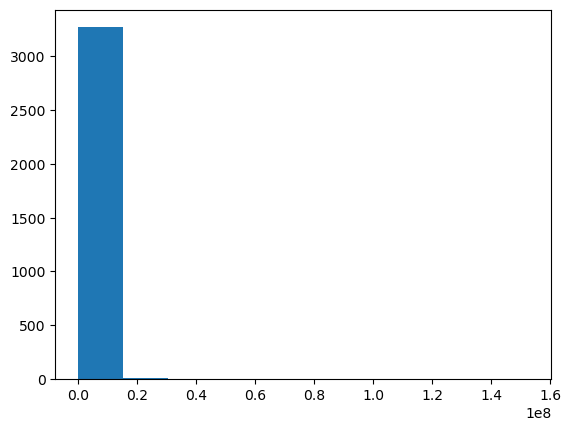

In [31]:
#Visualisation de la répartition des fréquentations par gare
plt.hist(df_gares_merged['total_voyageurs_non_voyageurs_2020'])

(array([ 16.,  32.,  92., 259., 639., 944., 774., 403., 121.,  11.]),
 array([ 0.        ,  1.88434913,  3.76869826,  5.65304739,  7.53739652,
         9.42174565, 11.30609478, 13.19044391, 15.07479304, 16.95914217,
        18.8434913 ]),
 <BarContainer object of 10 artists>)

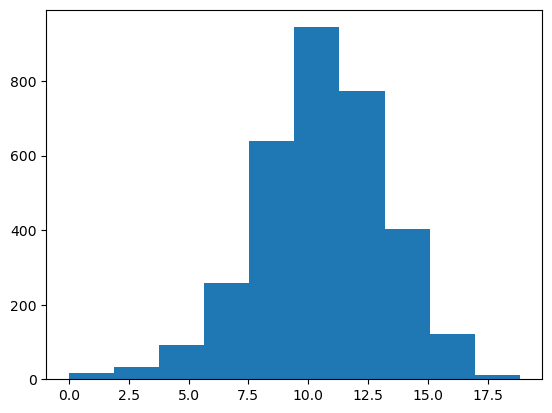

In [32]:
#Pour mieux apprécier les frequentations, il est nécessaire de passer au log
df_gares_merged['log_total_voyageurs_non_voyageurs_2020'] = np.log(df_gares_merged['total_voyageurs_non_voyageurs_2020'])
plt.hist(df_gares_merged['log_total_voyageurs_non_voyageurs_2020'])


In [33]:
#Enfin, application d'un filtre sur les frequentations : on ne garde que les gares les plus frequentées
df_gares_principales = df_gares_merged[df_gares_merged['log_total_voyageurs_non_voyageurs_2020']>= 14]

#On regarde ensuite quelles sont les gares très frequentées pour lesquelles il nous manque les coordonnees gps
#(ie les gares les plus fréquentées qui apparaissaient dans la database fréquentation mais pas dans la database liste-des-gares)
df_gares_manquantes  = df_gares_principales[df_gares_principales['x_wgs84'].isna()==True]
df_gares_manquantes


,code_uic,total_voyageurs_non_voyageurs_2020,nom_gare,x_wgs84,y_wgs84,log_total_voyageurs_non_voyageurs_2020
381,87756403,4085871,Monaco-Monte-Carlo,NaN,NaN,15.223045
650,87113795,3664906,Villiers-sur-Marne - Le Plessis-Trévise,NaN,NaN,15.114313
996,87113522,1562549,Le Chénay Gagny,NaN,NaN,14.261829
1214,87116038,1913470,Roissy-en-Brie,NaN,NaN,14.464429
1518,87758607,7980634,Châtelet les Halles,NaN,NaN,15.892528
1812,87113209,3862190,Pantin,NaN,NaN,15.166745
1814,87758904,107666015,Paris Gare du Nord,NaN,NaN,18.494545
1858,87654798,2865667,Rosa Parks,NaN,NaN,14.868312
1861,87113696,3206275,Rosny Bois Perrier,NaN,NaN,14.980620
2015,87116046,2496908,Émerainville - Pontault-Combault,NaN,NaN,14.730564


- **Problème** : il nous manque les données de gares importantes (la gare de Paris EST par exemple)
- **Solution** : ces gares étant -presque- toutes situées en région Ile de France (idf) on va aller chercher ces données sur l'API de la région idf.

On sort donc les données manquantes de ce dataframe et on va aller les chercher sur l'API idf (il nous manquera tout de même la gare de Monaco mais nous allons l'omettre car il ne s'agit que d'une gare et que Monaco n'est pas en France à proprement parlé).

In [16]:
#Elimination des gares dont on ne connait pas la fréquentation
df_gares_principales = df_gares_principales[df_gares_principales['x_wgs84'].isna()==False]
df_gares_principales

,code_uic,total_voyageurs_non_voyageurs_2020,nom_gare,x_wgs84,y_wgs84,log_total_voyageurs_non_voyageurs_2020
5,87741132,1236162,Aix-les-Bains le Revard,5.908901,45.688112,14.027522
6,87741132,1236162,Aix-les-Bains le Revard,5.908892,45.688219,14.027522
26,87271460,2177954,Aéroport Charles de Gaulle 1,2.555964,49.008827,14.593896
59,87113407,7412905,Bondy,2.478714,48.893901,15.818733
60,87113407,7412905,Bondy,2.477293,48.894395,15.818733
...,...,...,...,...,...,...
3302,87393157,2886249,Versailles Château Rive Gauche,2.129015,48.800261,14.875468
3304,87271437,3831144,Vert Galant,2.566815,48.944286,15.158674
3312,87721332,1657155,Villefranche-sur-Saône,4.721077,45.984561,14.320613
3314,87271510,2035390,Villeparisis - Mitry-le-Neuf,2.602848,48.953093,14.526198


In [19]:
#Récupération des données manquantes (sauf Monaco) grâce à l'API de la région idf

df_region_idf_initial = importer("https://data.iledefrance.fr/api/v2/catalog/datasets/gares-et-points-darrets-du-reseau-transilien/exports/json?limit=-1&offset=0&timezone=UTC")

#On se restreint aux gares dont les données geographiques sont manquantes dans le dataframe des gares principales
df_region_idf = df_region_idf_initial[df_region_idf_initial.code_uic.isin(df_gares_manquantes['code_uic'])==True]
df_region_idf



,code_uic,uic7,libelle_point_d_arret,libelle,libelle_stif_info_voyageurs,libelle_sms_gare,nom_gare,adresse,code_insee_commune,commune,x_lambert_ii_etendu,y_lambert_ii_etendu,coord_gps_wgs84,zone_navigo,gare_non_sncf
62,87113209,871132,PANTIN,PANTIN,GARE DE PANTIN,Pantin,Pantin,Avenue de la gare 93500 Pantin,93055,[Pantin],604688.0,2433279.0,"{'lon': 2.40040674765, 'lat': 48.8977738494}",2.0,0.0
166,87116038,871160,ROISSY EN BRIE,ROISSY EN BRIE,GARE DE ROISSY EN BRIE,Roissy en B.,Roissy-en-Brie,Place de la gare 77680 Roissy-en-Brie,77390,[Roissy-en-Brie],623033.0,2421933.0,"{'lon': 2.64984936854, 'lat': 48.7954076773}",5.0,0.0
207,87113696,871136,ROSNY BOIS PERRIER,ROSNY BOIS PERRIER,GARE DE ROSNY BOIS PERRIER,Rosny B. P.,Rosny-sous-Bois Perrier,Rue Léon Blum 93110 Rosny sous bois,93064,[Rosny-sous-Bois],610640.0,2431610.0,"{'lon': 2.48149612336, 'lat': 48.8827036731}",3.0,0.0
228,87654798,876547,Rosa Parks,Rosa Parks,GARE DE ROSA PARKS,None,Rosa Parks,Rue Gaston Tessier,75119,[Paris],602710.0,2433136.0,"{'lon': 2.37345, 'lat': 48.8965}",1.0,0.0
241,87113522,871135,LE CHENAY GAGNY,LE CHENAY GAGNY,GARE DE CHENAY GAGNY,Chenay-Gagny,Gagny le Chênay,5 rue du chemin de fer 93220 Gagny,93032,[Gagny],615860.0,2431016.0,"{'lon': 2.5526064160699997, 'lat': 48.8772579359}",4.0,0.0
326,87113795,871137,VILLIERS SUR MARNE PLESSIS TREVISE,VILLIERS SUR MARNE PLESSIS TREVISE,GARE DE VILLIERS SUR MARNE PLESSIS TREVISE,Villiers,Villiers-sur-Marne - Le Plessis-Trévise,place Pierre Sémard 94350 VILLIERS-SUR-MARNE,94079,[Villiers-sur-Marne],615121.0,2424997.0,"{'lon': 2.54232320839, 'lat': 48.8231802547}",4.0,0.0
327,87113779,871137,LES BOULLEREAUX CHAMPIGNY,LES BOULLEREAUX CHAMPIGNY,GARE DES BOULLEREAUX CHAMPIGNY,Boullereaux,Les Boullereaux Champigny,Avenue Danielle Casanova 94500 Champigny sur M...,94017,[Champigny-sur-Marne],612900.0,2425186.0,"{'lon': 2.51209824083, 'lat': 48.8249271629}",3.0,0.0
341,87113746,871137,NOGENT LE PERREUX,NOGENT LE PERREUX,GARE DE NOGENT LE PERREUX,Nogent le P.,Nogent - Le Perreux,place du Théâtre 94130 NOGENT-SUR-MARNE,94052,[Nogent-sur-Marne],611573.0,2426718.0,"{'lon': 2.4940770412199997, 'lat': 48.8387213192}",3.0,0.0
369,87113712,871137,VAL DE FONTENAY,VAL DE FONTENAY,GARE DE VAL DE FONTENAY,Val de Font.,Val de Fontenay,10 avenue du Val de Fontenay 94120 Fontenay-so...,94033,[Fontenay-sous-Bois],611300.0,2428798.0,"{'lon': 2.49041522851, 'lat': 48.8574201112}",3.0,0.0
404,87113704,871137,ROSNY SOUS BOIS,ROSNY SOUS BOIS,GARE DE ROSNY SOUS BOIS,Rosny Sous B,Rosny-sous-Bois,1 place des Martyrs de la Résistance 93110 ROS...,93064,[Rosny-sous-Bois],610943.0,2430279.0,"{'lon': 2.48559085409, 'lat': 48.8707365481}",3.0,0.0


**Remarque :** il nous manque encore la gare du Nord. En allant chercher manuellement la ligne correspondante, on remarque que c'est parce que le code uic est erroné (le code uic est différent dans les 2 bases). Après recherches, le vrai code uic est celui de la base idf. On le rectifie manuellement.

In [20]:
#Mise en évidence de l'erreur
print(df_region_idf_initial[df_region_idf_initial['libelle']=="PARIS NORD"][['libelle', 'code_uic']])
print(df_gares_manquantes[df_gares_manquantes['nom_gare']== "Paris Gare du Nord"][['nom_gare', 'code_uic']])


       libelle  code_uic
92  PARIS NORD  87271031
                nom_gare  code_uic
1814  Paris Gare du Nord  87758904


In [21]:
#Rectification de l'erreur, puis réiteration de l'opération qui récupère uniquement les gares manquantes
df_gares_manquantes.loc[df_gares_manquantes['nom_gare']=="Paris Gare du Nord", "code_uic"] = "87271031"
df_region_idf = df_region_idf_initial[df_region_idf_initial.code_uic.isin(df_gares_manquantes['code_uic'])==True]

#Pour simplifier, reset de l'index
df_region_idf.reset_index(inplace = True)
df_region_idf = df_region_idf.drop('index', axis=1)
df_region_idf

,code_uic,uic7,libelle_point_d_arret,libelle,libelle_stif_info_voyageurs,libelle_sms_gare,nom_gare,adresse,code_insee_commune,commune,x_lambert_ii_etendu,y_lambert_ii_etendu,coord_gps_wgs84,zone_navigo,gare_non_sncf
0,87113209,871132,PANTIN,PANTIN,GARE DE PANTIN,Pantin,Pantin,Avenue de la gare 93500 Pantin,93055,[Pantin],604688.0,2433279.0,"{'lon': 2.40040674765, 'lat': 48.8977738494}",2.0,0.0
1,87271031,872710,PARIS NORD (GARE DU NORD),PARIS NORD,GARE DU NORD SURFACE,Gare du Nord,Gare du Nord Surface,None,75110,[Paris],601529.0,2431239.0,"{'lon': 2.35733955798, 'lat': 48.8794550008}",1.0,0.0
2,87116038,871160,ROISSY EN BRIE,ROISSY EN BRIE,GARE DE ROISSY EN BRIE,Roissy en B.,Roissy-en-Brie,Place de la gare 77680 Roissy-en-Brie,77390,[Roissy-en-Brie],623033.0,2421933.0,"{'lon': 2.64984936854, 'lat': 48.7954076773}",5.0,0.0
3,87113696,871136,ROSNY BOIS PERRIER,ROSNY BOIS PERRIER,GARE DE ROSNY BOIS PERRIER,Rosny B. P.,Rosny-sous-Bois Perrier,Rue Léon Blum 93110 Rosny sous bois,93064,[Rosny-sous-Bois],610640.0,2431610.0,"{'lon': 2.48149612336, 'lat': 48.8827036731}",3.0,0.0
4,87654798,876547,Rosa Parks,Rosa Parks,GARE DE ROSA PARKS,None,Rosa Parks,Rue Gaston Tessier,75119,[Paris],602710.0,2433136.0,"{'lon': 2.37345, 'lat': 48.8965}",1.0,0.0
5,87113522,871135,LE CHENAY GAGNY,LE CHENAY GAGNY,GARE DE CHENAY GAGNY,Chenay-Gagny,Gagny le Chênay,5 rue du chemin de fer 93220 Gagny,93032,[Gagny],615860.0,2431016.0,"{'lon': 2.5526064160699997, 'lat': 48.8772579359}",4.0,0.0
6,87113795,871137,VILLIERS SUR MARNE PLESSIS TREVISE,VILLIERS SUR MARNE PLESSIS TREVISE,GARE DE VILLIERS SUR MARNE PLESSIS TREVISE,Villiers,Villiers-sur-Marne - Le Plessis-Trévise,place Pierre Sémard 94350 VILLIERS-SUR-MARNE,94079,[Villiers-sur-Marne],615121.0,2424997.0,"{'lon': 2.54232320839, 'lat': 48.8231802547}",4.0,0.0
7,87113779,871137,LES BOULLEREAUX CHAMPIGNY,LES BOULLEREAUX CHAMPIGNY,GARE DES BOULLEREAUX CHAMPIGNY,Boullereaux,Les Boullereaux Champigny,Avenue Danielle Casanova 94500 Champigny sur M...,94017,[Champigny-sur-Marne],612900.0,2425186.0,"{'lon': 2.51209824083, 'lat': 48.8249271629}",3.0,0.0
8,87113746,871137,NOGENT LE PERREUX,NOGENT LE PERREUX,GARE DE NOGENT LE PERREUX,Nogent le P.,Nogent - Le Perreux,place du Théâtre 94130 NOGENT-SUR-MARNE,94052,[Nogent-sur-Marne],611573.0,2426718.0,"{'lon': 2.4940770412199997, 'lat': 48.8387213192}",3.0,0.0
9,87113712,871137,VAL DE FONTENAY,VAL DE FONTENAY,GARE DE VAL DE FONTENAY,Val de Font.,Val de Fontenay,10 avenue du Val de Fontenay 94120 Fontenay-so...,94033,[Fontenay-sous-Bois],611300.0,2428798.0,"{'lon': 2.49041522851, 'lat': 48.8574201112}",3.0,0.0


In [22]:
#Récuperation des donnees gps pour la nouvelle base de donnees : séparation des données géographiques en 2 colonnes (latitude et longitude)

df_region_idf['x_wgs84'] = [0]*len(df_region_idf)
df_region_idf['y_wgs84'] = [0]*len(df_region_idf)

for i in range(len(df_region_idf)):
    df_region_idf.loc[i,'x_wgs84'] = df_region_idf['coord_gps_wgs84'][i]['lon']
    df_region_idf.loc[i,'y_wgs84'] = df_region_idf['coord_gps_wgs84'][i]['lat']
    
df_region_idf.head()

,code_uic,uic7,libelle_point_d_arret,libelle,libelle_stif_info_voyageurs,libelle_sms_gare,nom_gare,adresse,code_insee_commune,commune,x_lambert_ii_etendu,y_lambert_ii_etendu,coord_gps_wgs84,zone_navigo,gare_non_sncf,x_wgs84,y_wgs84
0,87113209,871132,PANTIN,PANTIN,GARE DE PANTIN,Pantin,Pantin,Avenue de la gare 93500 Pantin,93055,[Pantin],604688.0,2433279.0,"{'lon': 2.40040674765, 'lat': 48.8977738494}",2.0,0.0,2.400407,48.897774
1,87271031,872710,PARIS NORD (GARE DU NORD),PARIS NORD,GARE DU NORD SURFACE,Gare du Nord,Gare du Nord Surface,None,75110,[Paris],601529.0,2431239.0,"{'lon': 2.35733955798, 'lat': 48.8794550008}",1.0,0.0,2.357340,48.879455
2,87116038,871160,ROISSY EN BRIE,ROISSY EN BRIE,GARE DE ROISSY EN BRIE,Roissy en B.,Roissy-en-Brie,Place de la gare 77680 Roissy-en-Brie,77390,[Roissy-en-Brie],623033.0,2421933.0,"{'lon': 2.64984936854, 'lat': 48.7954076773}",5.0,0.0,2.649849,48.795408
3,87113696,871136,ROSNY BOIS PERRIER,ROSNY BOIS PERRIER,GARE DE ROSNY BOIS PERRIER,Rosny B. P.,Rosny-sous-Bois Perrier,Rue Léon Blum 93110 Rosny sous bois,93064,[Rosny-sous-Bois],610640.0,2431610.0,"{'lon': 2.48149612336, 'lat': 48.8827036731}",3.0,0.0,2.481496,48.882704
4,87654798,876547,Rosa Parks,Rosa Parks,GARE DE ROSA PARKS,None,Rosa Parks,Rue Gaston Tessier,75119,[Paris],602710.0,2433136.0,"{'lon': 2.37345, 'lat': 48.8965}",1.0,0.0,2.373450,48.896500


In [23]:
#Enfin, concaténation des dataframes venant de l'API SNCF et de l'API région IDF
df_complete_gares = pd.concat([df_gares_principales, df_region_idf], ignore_index = True)
df_complete_gares.head()

,code_uic,total_voyageurs_non_voyageurs_2020,nom_gare,x_wgs84,y_wgs84,log_total_voyageurs_non_voyageurs_2020,uic7,libelle_point_d_arret,libelle,libelle_stif_info_voyageurs,libelle_sms_gare,adresse,code_insee_commune,commune,x_lambert_ii_etendu,y_lambert_ii_etendu,coord_gps_wgs84,zone_navigo,gare_non_sncf
0,87741132,1236162.0,Aix-les-Bains le Revard,5.908901,45.688112,14.027522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,87741132,1236162.0,Aix-les-Bains le Revard,5.908892,45.688219,14.027522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,87271460,2177954.0,Aéroport Charles de Gaulle 1,2.555964,49.008827,14.593896,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,87113407,7412905.0,Bondy,2.478714,48.893901,15.818733,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,87113407,7412905.0,Bondy,2.477293,48.894395,15.818733,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<span style="color: #D32F2F">**3. Visualisation des données à travers une carte intéractive**</span>

In [24]:
#Visualisation de la map des gares sur le territoire français avec une carte intéractive

m = folium.Map(location=[45.8666, 2.3333], min_zoom=3, max_zoom=14, zoom_start=5.3, tiles = 'Stamen Terrain')
#affichage des gares principales dont on avait les donnees gps par l'API SNCF
for i in df_complete_gares.index:
    tooltip = df_complete_gares['nom_gare'][i]
    folium.Marker([df_complete_gares['y_wgs84'][i],df_complete_gares['x_wgs84'][i]], popup=df_complete_gares['nom_gare'][i], tooltip=tooltip).add_to(m)

m

On remarque que la gare **Paris EST**, dont les données géographiques manquaient dans la base de données initiale (API SNCF), apparaît bien.

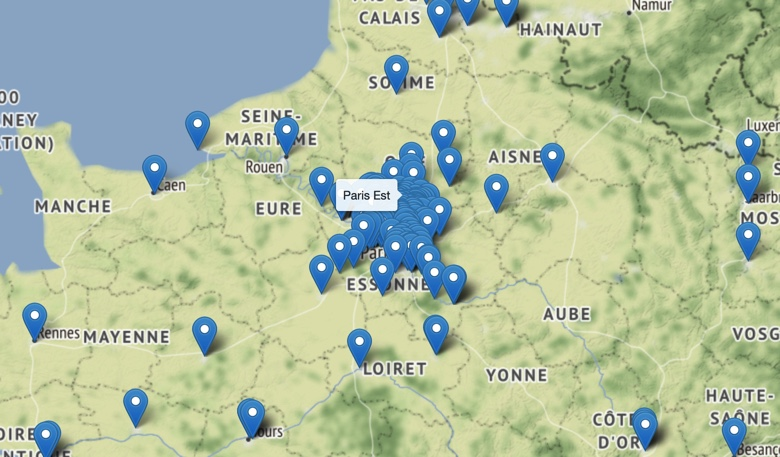